# **Data-driven Spatio-temporal Prediction of COVID-19 Pandemic Using an LSTM Network: A County-level Analysis in the US**




In [ ]:
import os 
import tensorflow as tf
from tensorflow import experimental
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Google Colab Pro were used for training: Hardware Accelerator: GPU, Runtime Shape: High-RAM
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
def predict_multistep_timeseries(df, counties, mean, std, model):
    '''
    Args:

        df: A dataframe of multiple time series
        counties: A list of counties 
        mean: Train set mean
        std: Train set std
        model: MTS-LSTM trained model

    Outputs:

        seriesall: Dynamics predictions

    '''
    
    seriesall = np.zeros((len(counties), TIMESERIES_LENGHT - WINDOW_SIZE, len(VARIABLES)))
    counter = 0
    for county in counties:
        mask = df.loc[:, 'GISJOIN'] == county
        d = df.loc[mask, VARIABLES]
        series = d.to_numpy()
        # Standardize input observations
        series = (series-mean) / std
        # Remove a number of observations from the beginning based on window size. 
        forecasts = series[WINDOW_SIZE:, :]

        # Forecast 4 weeks ahead
        for i in range(1, PRED_WEEKS + 1):
            ds = tf.data.Dataset.from_tensor_slices(series)
            ds = ds.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
            ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE + 1))
            ds2 = ds.map(lambda w: (w[:-1], w[-1:, :len(VARIABLES)]))
            ds3 = ds2.batch(BATCH_SIZE).prefetch(1)

            forecast = model.predict(ds3, use_multiprocessing=USE_MULTIPROCESSING)
            lstm_forecast = forecast[:, -1, :]
            lstm_forecast = np.concatenate((lstm_forecast[-1, :].reshape(1, len(VARIABLES))[0], 
                                            forecasts[-1, len(VARIABLES):]), axis=0)
             
            forecasts = np.concatenate((forecasts, np.array([lstm_forecast])))
            series = forecasts

        seriesall[counter, :, :] = series * std + mean
        counter = counter + 1
    
    return seriesall

def mean_variance_calculator(train_dataset):

    '''
    calculates mean and variance of the training set to standardize observations

    Args:
        train_dataset: Training set

    Outputs:
        [mean_train, std_train]: A list containing mean and standard deviation of training observations

    '''

    mean_train = np.mean(np.mean(list(train_dataset), axis=0), axis=0)
    std_train=[]
    for var in range(0, len(VARIABLES)):
        aux_std = []
        for item in train_dataset:
            aux_std.append(np.array(item)[:, var])
        std_train.append(np.std(np.array(aux_std)))

    return [mean_train, std_train]
    
def create_feature_vector(counties_sample, data_train_valid):
    '''
    Prepares feature vectors from multiple time series.
    Args:

        counties_sample:  A list of sample counties
        data_train_valid: A dataframe of multiple time series

    Outputs:

        feature_vectors: Feature vectors prepared for training.
    '''

    # Create features for series of each county using a sliding window
    for county in counties_sample:
        mask = data_train_valid.loc[:, 'GISJOIN'] == county
        d = data_train_valid.loc[mask, VARIABLES]
        series = d.to_numpy()
        ds = tf.data.Dataset.from_tensor_slices(series)
        """ 
        Use an extra step for window as the label. Make sure to drop the remainder 
        to avoid feature vectors of different length. Each feature vector has both 
        features and labels at this point.
        """
        ds = ds.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE + 1))
        if county == counties_sample[0]:
            feature_vectors = ds
        else:
            feature_vectors = feature_vectors.concatenate(ds)

    # Shuffle feature vectors from different series. 
    # Use the number of features to choose proper shuffle size 
    if SHUFFLE_TIMESERIES:
        shuffle_buffer = 1
        for item in feature_vectors:
            shuffle_buffer = shuffle_buffer + 1 
        return feature_vectors.shuffle(shuffle_buffer)
    else:
        return feature_vectors

# Input data

In [ ]:
# The length of timeseries for a county
TIMESERIES_LENGHT = 33 
# Use this variable to control the proportion of counties that are used in training process
PROP_SAMPLE_COUNTIES = 0.016 
# Number of weeks from which new predictionsa re made
WINDOW_SIZE = 3  
# Number of weeks to be predicted
PRED_WEEKS = 4 
# Variables to be used in the model
VARIABLES = ['confirmed_cases', 'deaths', 'foot_traffic'] 
# Whether or not shuffle the feature vectors from different counties
SHUFFLE_TIMESERIES = 1
BATCH_SIZE = 1024 
LEARNING_RATE = 1e-3
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON =1e-07
AMSGRAD = False
EPOCHS = 100
USE_MULTIPROCESSING = True

# Read Covid-19 time series data for 01/26/2020-09/26/2020
data = pd.read_csv('gdrive/MyDrive/ColabNotebooks/Covid19_01262020_09262020.zip', compression='zip') 
# 35 weeks of data is availbale in data set. The last two weeks are removed for the purpose of this research
data = data[data.loc[:, 'Date'] <= 230] # Refer to the data description column (Date)

# Randomly choose a proportion of counties for training using PROP_SAMPLE_COUNTIES variable 
counties = list(pd.unique(data.loc[:, 'GISJOIN']))
counties_sample = random.sample(counties, 
                                int(np.floor(len(counties)*(PROP_SAMPLE_COUNTIES))))
print('Training using ' + 
        str(len(counties_sample)) + 
        ' counties of ' + 
        str(len(counties)))

Training using 50 counties of 3142


# Train-Validation-Test sets

In [ ]:
''' 
Split dataset into train-validation, and test data sets. For selected counties, 
set aside the last four weeks for test and the rest for train-validation. Notice 
that in the end, we test the model for a four weeks horizon on the entire county sets.
'''
data_train_valid = data[data.loc[:, 'Date'] < 209]

# Prepare timeseries for training and validation. Refer to figure 7 in paper
feature_vectors = create_feature_vector(counties_sample, 
                                        data_train_valid)

# Split feature vectors into train and validation (70%-30%)
valid_dataset = feature_vectors.take(np.floor(0.3*len(list(feature_vectors)))) 
train_dataset = feature_vectors.skip(np.floor(0.3*len(list(feature_vectors))))

# Standardize training and validation data using mean and variance of training set
[mean_train, std_train] = mean_variance_calculator(train_dataset)
train_dataset_stnd = train_dataset.map(lambda x: (x-mean_train) / std_train)
valid_dataset_stnd = valid_dataset.map(lambda x: (x-mean_train) / std_train)

# Separate features and labels for validation set. The last item in each series is used as label
valid_dataset_stnd = valid_dataset_stnd.map(lambda w: (w[:-1], w[-1:, :len(VARIABLES)]))
# Create batches of validation set
valid_dataset_stnd= valid_dataset_stnd.batch(BATCH_SIZE).prefetch(1)

# Separate features and labels for training set. The last item in each series is used as label
train_dataset_stnd = train_dataset_stnd.map(lambda w: (w[:-1], w[-1:, :len(VARIABLES)]))
# Create batches of training set
train_dataset_stnd= train_dataset_stnd.batch(BATCH_SIZE).prefetch(1)

# Defining the model


Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.3970 - mae: 0.7143
Epoch 2/150
1/1 [==============================] - 0s 228ms/step - loss: 0.4209 - mae: 0.7382
Epoch 3/150
1/1 [==============================] - 0s 228ms/step - loss: 0.4463 - mae: 0.7665
Epoch 4/150
1/1 [==============================] - 0s 220ms/step - loss: 0.4135 - mae: 0.7307
Epoch 5/150
1/1 [==============================] - 0s 230ms/step - loss: 0.4015 - mae: 0.7199
Epoch 6/150
1/1 [==============================] - 0s 222ms/step - loss: 0.4467 - mae: 0.7724
Epoch 7/150
1/1 [==============================] - 0s 229ms/step - loss: 0.3931 - mae: 0.7100
Epoch 8/150
1/1 [==============================] - 0s 224ms/step - loss: 0.3994 - mae: 0.7137
Epoch 9/150
1/1 [==============================] - 0s 224ms/step - loss: 0.4322 - mae: 0.7539
Epoch 10/150
1/1 [==============================] - 0s 228ms/step - loss: 0.4268 - mae: 0.7462
Epoch 11/150
1/1 [==============================] - 0s 238ms/s

(1e-05, 0.1, 0.15, 0.9)

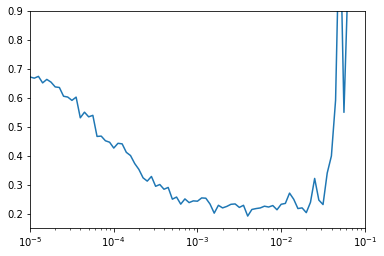

In [ ]:
# Using len(VARIABLE) control the number of input variables to the model.
model = tf.keras.models.Sequential([tf.keras.layers.BatchNormalization(input_shape=[None, len(VARIABLES)]),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True), 
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(len(VARIABLES)),
                                    tf.keras.layers.Lambda(lambda x: x * 100)
                                    ])

# Find the best learning rate (1e-3 is used as optimized learning rate in this research)
optimize_learning_rate = tf.keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(
    learning_rate = LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2, 
    epsilon= EPSILON, amsgrad = AMSGRAD,)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"])
history = model.fit(train_dataset_stnd, epochs=150, callbacks=[optimize_learning_rate]) 
plt.semilogx(history.history["lr"], history.history["mae"])
# Choose appropriate range when using different scenarios
plt.axis([1e-5, 1e-1, 0.15, 0.9])

# Training MTS-LSTM

Training...
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.3476 - mae: 0.6357 - val_loss: 0.1326 - val_mae: 0.3830
Epoch 2/100
1/1 [==============================] - 1s 613ms/step - loss: 0.2248 - mae: 0.4887 - val_loss: 0.1200 - val_mae: 0.3007
Epoch 3/100
1/1 [==============================] - 1s 678ms/step - loss: 0.1486 - mae: 0.3620 - val_loss: 0.1141 - val_mae: 0.3053
Epoch 4/100
1/1 [==============================] - 1s 618ms/step - loss: 0.1414 - mae: 0.3463 - val_loss: 0.1024 - val_mae: 0.2903
Epoch 5/100
1/1 [==============================] - 1s 642ms/step - loss: 0.1200 - mae: 0.3123 - val_loss: 0.1229 - val_mae: 0.2845
Epoch 6/100
1/1 [==============================] - 1s 616ms/step - loss: 0.1243 - mae: 0.2901 - val_loss: 0.0787 - val_mae: 0.2144
Epoch 7/100
1/1 [==============================] - 1s 619ms/step - loss: 0.1059 - mae: 0.2492 - val_loss: 0.0831 - val_mae: 0.2107
Epoch 8/100
1/1 [==============================] - 1s 633ms/step - loss: 0

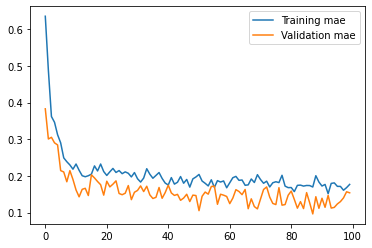

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.BatchNormalization(input_shape=[None, len(VARIABLES)]),
                                    tf.keras.layers.LSTM(128, return_sequences=True),
                                    tf.keras.layers.LSTM(128, return_sequences=True), 
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(len(VARIABLES)),
                                    tf.keras.layers.Lambda(lambda x: x * 100)
                                    ])

tf.keras.backend.clear_session()
print('Training...')
# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, 
                                        beta_1=BETA_1, 
                                        beta_2=BETA_2, 
                                        epsilon= EPSILON, 
                                        amsgrad = AMSGRAD,)
# Compile the model
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"])

# Train the model
history = model.fit(train_dataset_stnd, 
                    epochs=EPOCHS, 
                    use_multiprocessing=USE_MULTIPROCESSING, 
                    validation_data=valid_dataset_stnd)

# validate the model
valid_loss, valid_mae = model.evaluate(valid_dataset_stnd, 
                                        batch_size=BATCH_SIZE, 
                                        use_multiprocessing=USE_MULTIPROCESSING)
print('Validation loss: ' + 
        str(valid_loss), '\n' 'Validation MAE: ' + 
        str(valid_mae))

'''
Notice that validation MAE is less than Training MAE. This is because the dropout 
layer is not applied in validation while training. To check out, drop the drop out layer from the model.
'''
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Training mae', 'Validation mae'])


# Prediction

In [ ]:
print('Predicting the next four weeks for all counties ...')
seriesall = predict_multistep_timeseries(data_train_valid, 
                                            counties,
                                            mean_train, 
                                            std_train, 
                                            model,)
seriesall_bck = seriesall
seriesall = seriesall.clip(min=0)

Predicting the next four weeks for all counties ...


# Evaluation of predictions

In [ ]:
# Evaluate the predictions for all counties
print('Evaluation of predictions ...')
rmse_county = pd.DataFrame(index=(list(pd.unique(data_train_valid.GISJOIN))), 
                            columns=['rmse_confirmed', 'rmse_death'])

rmse_weekly = pd.DataFrame(index=['w' + str(x) for x in list(range(1, PRED_WEEKS+1))], 
                            columns=['rmse_confirmed', 'rmse_death'])

rmse_all = pd.DataFrame(index=['all'], 
                        columns=['rmse_confirmed', 'rmse_death'])

# RMSE by county (see equation 7 in paper)
for item in list(pd.unique(data_train_valid.GISJOIN)):

    smplCntyIdx = list(pd.unique(data_train_valid.GISJOIN)).index(item)
    mask = data.loc[:, 'GISJOIN'] == item
    d = data.loc[mask, ['confirmed_cases', 'deaths']]
    series = d.to_numpy()

    rmse_county.loc[item, ['rmse_confirmed']] = np.sqrt(mean_squared_error(series[-PRED_WEEKS:, 0], seriesall[smplCntyIdx,-PRED_WEEKS:, 0]))
    
    rmse_county.loc[item, ['rmse_death']] = np.sqrt(mean_squared_error(series[-PRED_WEEKS:, 1], seriesall[smplCntyIdx,-PRED_WEEKS:, 1]))

data2 = np.array(data.loc[:, ['confirmed_cases', 'deaths']]).reshape((len(counties), TIMESERIES_LENGHT, 2))

# RMSE by week (see equation 8 in paper)
for w in rmse_weekly.index:
    rmse_weekly.loc[w,'rmse_confirmed'] = np.sqrt(mean_squared_error(data2[:, -(PRED_WEEKS-int(w[1])+1), 0], seriesall[:,-(PRED_WEEKS-int(w[1])+1), 0]))
    rmse_weekly.loc[w,'rmse_death'] = np.sqrt(mean_squared_error(data2[:, -(PRED_WEEKS-int(w[1])+1), 1], seriesall[:,-(PRED_WEEKS-int(w[1])+1), 1]))

print('RMSE by week', rmse_weekly)

# RMSE total (see equation 9 in paper)
rmse_all.loc['all','rmse_confirmed'] = np.sqrt(mean_squared_error(data2[:, -PRED_WEEKS:, 0], seriesall[:,-PRED_WEEKS:, 0]))
rmse_all.loc['all','rmse_death'] = np.sqrt(mean_squared_error(data2[:, -PRED_WEEKS:, 1], seriesall[:,-PRED_WEEKS:, 1]))

print('\n RMSE (total)', rmse_all)


Evaluation of predictions ...
RMSE by week    rmse_confirmed rmse_death
w1        283.969    9.99319
w2        229.122    8.58614
w3        223.273    8.32907
w4        167.366     8.0922

 RMSE (total)     rmse_confirmed rmse_death
all        229.672    8.78127
